# PROJECT: DỰ BÁO TẢI ĐIỆN VN

1. [I. Data processing & Data exploration](#1)
1. [II. Feature engineering](#2)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

<a id="1"></a>
## I. Data processing & Data exploration


### process df_Elog

In [2]:
import pandas as pd
import numpy as np
Elog = 'dataset/HCM02-ELog.csv'
df_Elog = pd.read_csv(Elog, parse_dates=True)

df_Elog['time'] = pd.to_datetime(df_Elog['received_time']).to_numpy()

df_Elog.drop("Unnamed: 0",axis=1, inplace=True)
df_Elog.drop("received_time",axis=1, inplace=True)
df_Elog.set_index("time", inplace=True)

df_Elog.sort_index(inplace=True)
df_Elog['using_in_time'] = df_Elog.groupby(['meter_id'])['meter_idx'].diff()

# lần 1: loại bỏ các thành phần outlier lớn
median = df_Elog['using_in_time'].median()
std = df_Elog['using_in_time'].std()
outliers = (df_Elog['using_in_time'] - median).abs() > std

df_Elog['using_in_time'][outliers] = np.nan
df_Elog['using_in_time'].fillna(median, inplace=True)

# lần 2: tính lại median và std để kéo outlier gần hơn
median = df_Elog['using_in_time'].median()
std = df_Elog['using_in_time'].std()
outliers = (df_Elog['using_in_time'] - median).abs() > std

df_Elog['using_in_time'][outliers] = np.nan
df_Elog['using_in_time'].fillna(median, inplace=True)

# fill < 0
outliers = df_Elog['using_in_time']<0
df_Elog['using_in_time'][outliers] = np.nan
df_Elog['using_in_time'].fillna(median, inplace=True)

daily_df = pd.DataFrame()

daily_df['using_daily'] = df_Elog.groupby(['customer_id', 'meter_id', 'source'])['using_in_time'].resample('D').sum()
daily_df.reset_index(['customer_id', 'meter_id', 'source', 'time'], inplace=True)
daily_df.set_index("time", inplace=True)
daily_df.sort_index(inplace=True)

# daily_df.resample('1D')
noise = daily_df['using_daily'] == 0
daily_df['using_daily'][noise] = np.nan
daily_df['using_daily'].interpolate(method='linear', limit_direction='both', axis=0, inplace=True)
daily_df['Time'] = daily_df.index

daily_df

,customer_id,meter_id,source,using_daily,Time
time,,,,,
2019-01-01,EX0096469,MEXE8189994,train,17.1045,2019-01-01
2019-01-01,EX0039452,MEXE7028634,train,3.2760,2019-01-01
2019-01-01,EX0075862,MEXE17029978,train,55.5660,2019-01-01
2019-01-01,EX0029813,MEXE7516962,train,5.1030,2019-01-01
2019-01-01,EX0079335,MEXE8194505,train,7.1505,2019-01-01
...,...,...,...,...,...
2020-12-31,EX0081683,MEXE806018287,test,11.9280,2020-12-31
2020-12-31,EX0054920,MEXE8552181,test,8.5260,2020-12-31
2020-12-31,EX0067092,MEXE8165236,test,33.2535,2020-12-31


In [3]:
daily_df.head()

,customer_id,meter_id,source,using_daily,Time
time,,,,,
2019-01-01,EX0096469,MEXE8189994,train,17.1045,2019-01-01
2019-01-01,EX0039452,MEXE7028634,train,3.2760,2019-01-01
2019-01-01,EX0075862,MEXE17029978,train,55.5660,2019-01-01
2019-01-01,EX0029813,MEXE7516962,train,5.1030,2019-01-01
2019-01-01,EX0079335,MEXE8194505,train,7.1505,2019-01-01


In [4]:
daily_df.isnull().sum()

customer_id    0
meter_id       0
source         0
using_daily    0
Time           0
dtype: int64

In [5]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105026 entries, 2019-01-01 to 2020-12-31
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  105026 non-null  object        
 1   meter_id     105026 non-null  object        
 2   source       105026 non-null  object        
 3   using_daily  105026 non-null  float64       
 4   Time         105026 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.8+ MB


In [6]:
daily_df.shape

(105026, 5)

In [7]:
daily_df.describe()

,using_daily
count,105026.000000
mean,11.127989
std,10.188031
min,0.001050
25%,3.969000
50%,7.948500
75%,15.015000
max,76.786500


### Process df_Eprofile

In [8]:
EProfile = 'dataset/HCM02-EProfile.csv'
df_EProfile = pd.read_csv(EProfile)

c_Pro = df_EProfile['customer_id'].unique()
profile = df_EProfile.astype({'registration_date':'datetime64[ns]'})

profile.rename(columns={"Unnamed: 0": "Row_ID"}, inplace=True)
profile.sort_values(by='Row_ID')

dup = profile.groupby('customer_id').count().reset_index()
dup = dup[dup['Row_ID'] > 1]

profile['city'] = (profile.groupby('customer_id')['city'].transform('first'))
profile['sector'] = (profile.groupby('customer_id')['sector'].transform('first'))
profile[profile['customer_id'].isin(dup['customer_id'])].sort_values(by='customer_id')

#remove duplicates by getting the min registration_date of each customer_id
profile = profile.sort_values('registration_date', ascending=True).drop_duplicates('customer_id').sort_index()
profile[profile['customer_id'].isin(dup['customer_id'])].sort_values(by='customer_id')

min_date = profile.groupby(['customer_id'])['registration_date'].min().reset_index()
mod_city = profile['city'].mode()[0]
mod_sector = profile['sector'].mode()[0]

#fill na for city and sector
profile['city'].fillna(mod_city, inplace=True)
profile['sector'].fillna(mod_sector, inplace = True)

#reshape table EProfile includes only necessary fields for the join
profile = profile[['customer_id','registration_date','city','sector']]

profile

,customer_id,registration_date,city,sector
0,EX0031924,2018-11-27,HPG,Agriculture
1,EX0011899,2018-08-01,VPC,Domestic
2,EX0028218,2007-06-18,BDG,Domestic
3,EX0011584,2018-01-06,HNI,Industry
4,EX0069549,2018-12-24,VPC,Entertainment
...,...,...,...,...
167,EX0056847,2017-12-25,KTM,Entertainment
168,EX0080742,2017-02-07,BDG,Entertainment
169,EX0093221,2012-12-21,DNI,Domestic
170,EX0079513,2017-04-10,VPC,Domestic


In [9]:
profile.shape

(159, 4)

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 171
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        159 non-null    object        
 1   registration_date  159 non-null    datetime64[ns]
 2   city               159 non-null    object        
 3   sector             159 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 6.2+ KB


In [11]:
profile.describe()

,customer_id,registration_date,city,sector
count,159,159,159,159
unique,159,153,7,9
top,EX0031924,2019-10-31 00:00:00,DNI,Domestic
freq,1,2,40,78
first,NaN,2002-01-05 00:00:00,NaN,NaN
last,NaN,2020-06-24 00:00:00,NaN,NaN


In [12]:
profile.city.nunique(), 'city', profile.sector.nunique(), 'sector'

(7, 'city', 9, 'sector')

### Merge Elog & Eprofile

In [13]:
Profile_Elog = pd.merge(profile, daily_df, how='inner', on='customer_id')
Profile_Elog = Profile_Elog.sort_values(by='Time').reset_index().drop('index',axis=1)

In [14]:
Profile_Elog

,customer_id,registration_date,city,sector,meter_id,source,using_daily,Time
0,EX0045185,2006-09-22,KTM,Domestic,MEXE8191827,train,5.51250,2019-01-01
1,EX0048706,2007-04-14,BDG,Domestic,MEXE6547259,train,9.11400,2019-01-01
2,EX0015825,2016-09-26,KTM,Entertainment,MEXE8980560,train,12.58005,2019-01-01
3,EX0056847,2017-12-25,KTM,Entertainment,MEXE8292231,train,21.37800,2019-01-01
4,EX0018969,2019-06-04,HNI,Industry,MEXE8980683,train,2.49165,2019-01-01
...,...,...,...,...,...,...,...,...
90227,EX0089523,2017-02-15,HPG,Entertainment,MEXE8564881,test,15.51375,2020-12-31
90228,EX0087834,2018-11-07,BDG,Retail,MEXE9480755,test,19.34940,2020-12-31
90229,EX0020077,2019-11-13,SG,Entertainment,MEXE7545218,test,0.42000,2020-12-31
90230,EX0015825,2016-09-26,KTM,Entertainment,MEXE17029979,test,29.11650,2020-12-31


In [15]:
daily_df.customer_id.nunique(), profile.customer_id.nunique()

(187, 159)

In [16]:
Profile_Elog.astype(bool).sum(axis=0)

customer_id          90232
registration_date    90232
city                 90232
sector               90232
meter_id             90232
source               90232
using_daily          90232
Time                 90232
dtype: int64

In [17]:
Profile_Elog.groupby('city').count()

,customer_id,registration_date,sector,meter_id,source,using_daily,Time
city,,,,,,,
BDG,10572,10572,10572,10572,10572,10572,10572
DNI,22293,22293,22293,22293,22293,22293,22293
HNI,14150,14150,14150,14150,14150,14150,14150
HPG,7534,7534,7534,7534,7534,7534,7534
KTM,13530,13530,13530,13530,13530,13530,13530
SG,8146,8146,8146,8146,8146,8146,8146
VPC,14007,14007,14007,14007,14007,14007,14007


In [18]:
Profile_Elog.groupby('city')['using_daily'].mean()

city
BDG    13.196294
DNI     9.736921
HNI    11.339003
HPG     9.900565
KTM    13.441294
SG      8.920378
VPC    11.498271
Name: using_daily, dtype: float64

In [19]:
Profile_Elog[Profile_Elog['city']=='SG']['using_daily'].sum()/8146

8.920378026350058

### Process weather

In [20]:
EWeather = 'dataset/HCM02-EWeather.csv'
weather = pd.read_csv(EWeather, sep='\t')
#rename column "Unnamed:0" and set it as an index
weather.rename(columns={"Unnamed: 0": "Row_ID"}, inplace=True)

#convert date to datetime
weather = weather.astype({'date':'datetime64[ns]'})

#convert weather factors to float
cols = ['temp','dew_point','humidity','cloud_cover','wind_speed','visibility','pressure','wind_bearing']
weather[cols] = weather[cols].astype('float64')

#replace value = -1 with np.nan
weather['city']=weather['city'].replace('-1', np.nan)
weather['trend']=weather['trend'].replace('-1', np.nan)
weather['summary']=weather['summary'].replace('-1', np.nan)

#check if -1 on each column
weather[(weather['trend'] == '-1') | (weather['city'] == '-1') | weather['summary'] == '-1'].count()

# for records having city as null, cause it's non-sense if it has data for weather of null city --> drop rows with city = null

#drop rows with city is null
indexcity = weather[(weather['city'].isnull())].index
weather.drop(indexcity , inplace=True)


# Handle nulls for weather factors

#sort dataset by city then by date ascending
weather.sort_values(by=['city','date'], inplace=True,
               ascending = [True, True])

#split date into record_date without time
weather['recorded_date'] = weather['date'].dt.date

#fill null for trend and summary by mode by city by date
weather['trend'] = weather["trend"].fillna(weather.groupby(['city','recorded_date'])['trend'].transform( 
                                        lambda x: x.value_counts().index[0])
                                      )

weather['summary'] = weather["summary"].fillna(weather.groupby(['city','recorded_date'])['summary'].transform( 
                                        lambda x: x.value_counts().index[0])
                                      )


#Fill null temp by median temp groupby city and by date
weather['temp'] = weather["temp"].fillna(weather.groupby(['city','recorded_date'])['temp'].transform('median'))

#Fill null dew_point by median dew_point groupby city and by date
weather['dew_point'] = weather["dew_point"].fillna(weather.groupby(['city','recorded_date'])['dew_point'].transform('median'))

#Fill null weather factors by median values groupby city and by date
weather['humidity'] = weather["humidity"].fillna(weather.groupby(['city','recorded_date'])['humidity'].transform('median'))
weather['cloud_cover'] = weather["cloud_cover"].fillna(weather.groupby(['city','recorded_date'])['cloud_cover'].transform('median'))
weather['wind_speed'] = weather["wind_speed"].fillna(weather.groupby(['city','recorded_date'])['wind_speed'].transform('median'))
weather['visibility'] = weather["visibility"].fillna(weather.groupby(['city','recorded_date'])['visibility'].transform('median'))
weather['pressure'] = weather["pressure"].fillna(weather.groupby(['city','recorded_date'])['pressure'].transform('median'))

weather['wind_bearing'] = weather["wind_bearing"].fillna(weather.groupby(['city','recorded_date'])['wind_bearing'].transform('median'))


weather['pressure'] = weather["pressure"].fillna(weather.groupby(['city'])['pressure'].transform('median'))


#Group EWeather by date
weather['date'] = weather['date'].dt.normalize()

weather.drop(['Row_ID','recorded_date'], axis=1, inplace=True)
weather_measure = weather.groupby(['date','city']).median().reset_index()

weather_dim = weather[['date','city','trend','summary']]
weather_dim = weather_dim.groupby(['date','city'],as_index=False).agg(lambda x:x.value_counts().index[0])

weather_by_date  = pd.merge(left=weather_dim, right=weather_measure, on=['date', 'city'], how='inner')

# fill data 31/12/2020
q = weather_by_date.loc[len(weather_by_date.index)-1]
q[:] = pd.np.nan
q['date'] = weather_by_date.loc[len(weather_by_date.index)-1]['date'] + pd.Timedelta(days=1)

for city in weather_by_date.city.unique():
    q['city'] = city
    weather_by_date.loc[len(weather_by_date.index)] = q

# fill data 29/2/2020
q = weather_by_date.loc[len(weather_by_date.index)-1]
q[:] = pd.np.nan
q['date'] = pd.Timestamp(2020, 2, 29)
for city in weather_by_date.city.unique():
    q['city'] = city
    weather_by_date.loc[len(weather_by_date.index)] = q
    

weather_by_date.sort_values(by=['city','date'], inplace=True, ascending = [True, True])
weather_by_date.interpolate(method='ffill',  inplace=True)
weather_by_date['Time'] = weather_by_date['date']
weather_by_date

,date,city,trend,summary,temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing,Time
0,2019-01-01,BDG,partly-cloudy-night,Mostly Cloudy,23.010,19.000,0.780,0.750,1.500,6.000,1016.210,60.0,2019-01-01
7,2019-01-02,BDG,partly-cloudy-night,Mostly Cloudy,23.010,20.000,0.830,0.750,1.500,6.000,1014.800,71.0,2019-01-02
14,2019-01-03,BDG,partly-cloudy-night,Mostly Cloudy,22.020,21.500,0.940,0.750,1.500,5.010,1014.200,320.0,2019-01-03
21,2019-01-04,BDG,partly-cloudy-night,Mostly Cloudy,23.010,22.010,0.940,0.750,1.500,5.010,1012.855,90.0,2019-01-04
28,2019-01-05,BDG,partly-cloudy-night,Mostly Cloudy,23.010,22.010,0.940,0.750,1.500,6.000,1011.595,311.0,2019-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,2020-12-27,VPC,partly-cloudy-night,Partly Cloudy,21.815,19.745,0.880,0.710,2.305,16.093,1016.500,66.0,2020-12-27
5088,2020-12-28,VPC,partly-cloudy-day,Mostly Cloudy,21.465,19.995,0.910,0.620,2.050,16.093,1016.450,33.5,2020-12-28
5095,2020-12-29,VPC,partly-cloudy-night,Mostly Cloudy,22.020,20.975,0.915,0.875,2.025,16.093,1015.500,33.0,2020-12-29
5102,2020-12-30,VPC,rain,Possible Light Rain,22.240,20.725,0.920,0.880,2.045,16.093,1016.600,304.0,2020-12-30


### Merge Elog & Eprofile & Weather

In [21]:
df_final= pd.merge(Profile_Elog, weather_by_date, on=['city', 'Time'], how='left')
df_final.drop(['registration_date', 'date'], axis=1, inplace=True)
df_final

,customer_id,city,sector,meter_id,source,using_daily,Time,trend,summary,temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing
0,EX0045185,KTM,Domestic,MEXE8191827,train,5.51250,2019-01-01,partly-cloudy-night,Mostly Cloudy,23.060,19.000,0.780,0.750,1.500,7.000,1016.21,60.0
1,EX0048706,BDG,Domestic,MEXE6547259,train,9.11400,2019-01-01,partly-cloudy-night,Mostly Cloudy,23.010,19.000,0.780,0.750,1.500,6.000,1016.21,60.0
2,EX0015825,KTM,Entertainment,MEXE8980560,train,12.58005,2019-01-01,partly-cloudy-night,Mostly Cloudy,23.060,19.000,0.780,0.750,1.500,7.000,1016.21,60.0
3,EX0056847,KTM,Entertainment,MEXE8292231,train,21.37800,2019-01-01,partly-cloudy-night,Mostly Cloudy,23.060,19.000,0.780,0.750,1.500,7.000,1016.21,60.0
4,EX0018969,HNI,Industry,MEXE8980683,train,2.49165,2019-01-01,partly-cloudy-night,Mostly Cloudy,23.000,19.000,0.780,0.750,1.800,6.500,1016.21,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90227,EX0089523,HPG,Entertainment,MEXE8564881,test,15.51375,2020-12-31,cloudy,Partly Cloudy,19.590,19.090,0.970,0.730,0.790,16.093,1016.90,304.0
90228,EX0087834,BDG,Retail,MEXE9480755,test,19.34940,2020-12-31,rain,Mostly Cloudy,22.935,20.850,0.865,0.800,2.480,16.093,1016.50,322.0
90229,EX0020077,SG,Entertainment,MEXE7545218,test,0.42000,2020-12-31,partly-cloudy-day,Mostly Cloudy,22.840,20.950,0.900,0.800,2.000,16.093,1016.30,312.0
90230,EX0015825,KTM,Entertainment,MEXE17029979,test,29.11650,2020-12-31,rain,Possible Light Rain,22.860,22.240,0.950,0.835,3.030,16.093,1016.60,323.0


In [22]:
df_final.describe(include='all').T
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90232 entries, 0 to 90231
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   customer_id   90232 non-null  object        
 1   city          90232 non-null  object        
 2   sector        90232 non-null  object        
 3   meter_id      90232 non-null  object        
 4   source        90232 non-null  object        
 5   using_daily   90232 non-null  float64       
 6   Time          90232 non-null  datetime64[ns]
 7   trend         90232 non-null  object        
 8   summary       90232 non-null  object        
 9   temp          90232 non-null  float64       
 10  dew_point     90232 non-null  float64       
 11  humidity      90232 non-null  float64       
 12  cloud_cover   90232 non-null  float64       
 13  wind_speed    90232 non-null  float64       
 14  visibility    90232 non-null  float64       
 15  pressure      90232 non-null  float6

<a id="2"></a>
## II. Feature Engineering

In [23]:
mean_sector = df_final.groupby(['sector'])['using_daily'].mean()
for i in range(len(df_final)):
    df_final_i = df_final.loc[i]
    sector = df_final_i.sector
    df_final.loc[i, 'sector'] = mean_sector[sector]
df_final['sector'] = df_final['sector'].astype('float64')
df_final


mean_sector = df_final.groupby(['city'])['using_daily'].mean()
for i in range(len(df_final)):
    df_final_i = df_final.loc[i]
    city = df_final_i.city
    df_final.loc[i, 'city'] = mean_sector[city]
df_final['city'] = df_final['city'].astype('float64')
df_final

mean_sector = df_final.groupby(['trend'])['using_daily'].mean()
for i in range(len(df_final)):
    df_final_i = df_final.loc[i]
    trend = df_final_i.trend
    df_final.loc[i, 'trend'] = mean_sector[trend]
df_final['trend'] = df_final['trend'].astype('float64')
df_final

mean_sector = df_final.groupby(['summary'])['using_daily'].mean()
for i in range(len(df_final)):
    df_final_i = df_final.loc[i]
    summary = df_final_i.summary
    df_final.loc[i, 'summary'] = mean_sector[summary]
df_final['summary'] = df_final['summary'].astype('float64')
df_final


index_log = df_final[df_final['Time'] == pd.Timestamp(2020, 2, 29)].index
df_final.drop(index_log , inplace=True)

In [24]:
df_final.to_csv('Feature_Engineering.csv')

<a id="3"></a>
## III. Predictive modeling


### test model

In [25]:
import statsmodels.api as sm


x1 = df_final[df_final['source'] == 'train'].drop(['using_daily','customer_id', 'meter_id','Time', 'source'], axis = 1) 
y = df_final[df_final['source'] == 'train']['using_daily']

x = sm.add_constant(x1)

results = sm.OLS(y,x).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            using_daily   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     937.9
Date:                Wed, 23 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:46:47   Log-Likelihood:            -2.7664e+05
No. Observations:               75364   AIC:                         5.533e+05
Df Residuals:                   75351   BIC:                         5.534e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           31.1653     14.793      2.107      0.035       2.170      60.160
city             0.9551      0.023     41.839      0.000       0.910       1.000
sector           0.9809      0.011     93.179      0.000       0.960       1.002
trend           -0.1196      0.145     -0.828      0.408      -0.403       0.164
summary          0.2623      0.105      2.492      0.013       0.056       0.469
temp             0.0696      0.054      1.290      0.197      -0.036       0.175
dew_point       -0.0036      0.057     -0.063      0.950      -0.116       0.109
humidity        -2.9075      1.150     -2.528      0.011      -5.161      -0.654
cloud_cover     -0.1711      0.168     -1.017      0.309      -0.501       0.159
wind_speed       0.0316      0.051      0.622      0.534      -0.068       0.131
visibility       0.0740      0.015      4.795      0.000       0.044       0.104
pressure        -0.0428      0.014     -3.066      0.002      -0.070      -0.015
wind_bearing     0.0002      0.001      0.335      0.738      -0.001       0.001
==============================================================================
Omnibus:                    16172.819   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36542.415
Skew:                           1.227   Prob(JB):                         0.00
Kurtosis:                       5.370   Cond. No.                     4.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No handles with labels found to put in legend.


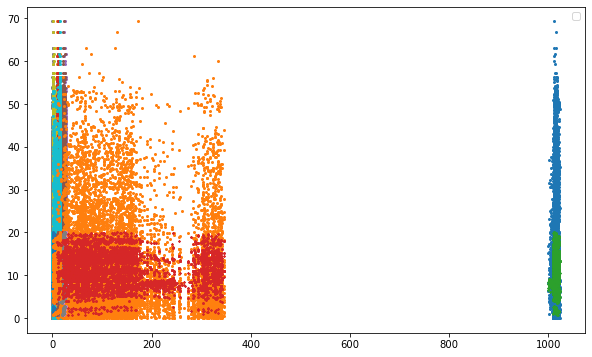

In [26]:
batch_size = -1
x2 = df_final[df_final['source'] == 'test'].drop(['using_daily','customer_id', 'meter_id','Time', 'source'], axis = 1)[:batch_size]
y_acture = df_final[df_final['source'] == 'test']['using_daily'][:batch_size]

x = sm.add_constant(x2)
y_pred  = results.predict(x)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# fig, ax = plt.subplots()

plt.plot(x2, y_acture, "o", markersize=2)

plt.plot(x2, y_pred, "*", markersize=2)
plt.legend()

In [27]:
df_final.head(1)

,customer_id,city,sector,meter_id,source,using_daily,Time,trend,summary,temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing
0,EX0045185,13.441294,8.717675,MEXE8191827,train,5.5125,2019-01-01,10.832308,10.417605,23.06,19.0,0.78,0.75,1.5,7.0,1016.21,60.0


## View data

<AxesSubplot:>

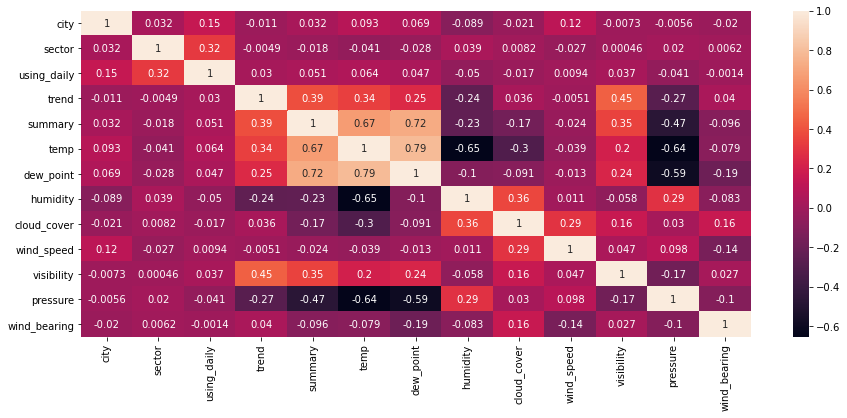

In [28]:
corr_matrix = df_final.corr()

fig, ax = plt.subplots(figsize = (15,6))
sns.heatmap(corr_matrix, annot = True)

<a id="4"></a>
## IV. Evaluation
